In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook
# import load_raw as Raw
import seaborn as sns
from scipy.special import expit as logit
from sklearn.model_selection import train_test_split
from scipy.special import expit as sigmoid # is more stable in case of overflows
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, \
recall_score, precision_score, accuracy_score, confusion_matrix
import math

from os import listdir
import random

# Prepare data

In [12]:
def HeaderMaker(PatientFile):
#     df_cleaned = pd.read_csv('/data/ortho/' + PatientFile, header=None)
    df_cleaned = pd.read_csv(PatientFile, header=None)

    df_cleaned = df_cleaned.rename(columns={0: "thorax_r_x", 1: "thorax_r_y", 2: "thorax_r_z"})
    df_cleaned = df_cleaned.rename(columns={3: "clavicula_r_x", 4: "clavicula_r_y", 5: "clavicula_r_z"})
    df_cleaned = df_cleaned.rename(columns={6: "scapula_r_x", 7: "scapula_r_y", 8: "scapula_r_z"})
    df_cleaned = df_cleaned.rename(columns={9: "humerus_r_x", 10: "humerus_r_y", 11: "humerus_r_z"})
    df_cleaned = df_cleaned.rename(columns={12: "ellebooghoek_r"})
    df_cleaned = df_cleaned.rename(columns={15: "thorax_l_x", 16: "thorax_l_y", 17: "thorax_l_z"})
    df_cleaned = df_cleaned.rename(columns={18: "clavicula_l_x", 19: "clavicula_l_y", 20: "clavicula_l_z"})
    df_cleaned = df_cleaned.rename(columns={21: "scapula_l_x", 22: "scapula_l_y", 23: "scapula_l_z"})
    df_cleaned = df_cleaned.rename(columns={24: "humerus_l_x", 25: "humerus_l_y", 26: "humerus_l_z"})
    df_cleaned = df_cleaned.rename(columns={27: "ellebooghoek_l"})
    
    return df_cleaned

def CreateList(keywordslist):
    allitems = listdir('/datc/ortho/Cleaning/step2')
    filteredlist = []
    for i in keywordslist:
        for x in allitems:
            if (i in x):
                filteredlist.append(x)
        allitems = filteredlist
        filteredlist = []
    finallist = []
    for i in allitems:
        finallist.append('/datc/ortho/Cleaning/step2/%s' % i)
    return finallist

In [13]:
AllOefeningen = CreateList(['meting'])
SuperCleaned = {'dir':[],
               'Cat':[],
               'pat':[],
               'meting':[],
               'oef':[],
               'split':[],
               'groundtruth':[]}

# Format de oefeningen
for i in AllOefeningen:
    splitted = i.split('_')
    SuperCleaned['dir'].append(i)
    SuperCleaned['Cat'].append(splitted[0].split('/')[-1])
    SuperCleaned['pat'].append(splitted[1])
    SuperCleaned['meting'].append(splitted[2])
    SuperCleaned['oef'].append(splitted[3])
    SuperCleaned['split'].append(splitted[4].split('.')[0])
    SuperCleaned['groundtruth'].append(int(splitted[0].split('/')[-1][3:]) * 1000 + int(splitted[3][3:]))

df_SuperCleaned = pd.DataFrame.from_dict(SuperCleaned)
# Pak welke oefeningen unique zijn
UniqueOefeningen = list(set(SuperCleaned['groundtruth']))


In [38]:
df_cleaned = pd.read_csv('../2. miscellaneous/AllPatients_SuperCleaned.csv',  sep= ';')

# split oorsprong kolom in onderdelen
x,y = df_cleaned['Oorsprong'].str.split(".").str #Oordprong word vertaald naar een string en wordt gesplits op de punt
df_cleaned['cat'],df_cleaned['pat'],df_cleaned['meting'],df_cleaned['oef'],df_cleaned['split'] = x.str.split("_").str #4 categorieen gemaakt obv file name
df_cleaned['cat'] = [ int(x[3:]) for x in df_cleaned['cat']] #voor elk 3+ element in de kolom wordt vertaald naar een int
df_cleaned['meting'] = [ int(x[6:]) for x in df_cleaned['meting']] 
df_cleaned['oef'] = [ int(x[3:]) for x in df_cleaned['oef']] 
df_cleaned['pat'] = [ int(x[3:]) for x in df_cleaned['pat']] 
df_cleaned['split'] = [ int(x[5:]) for x in df_cleaned['split']] 

#Calculate groundtruth
df_cleaned['groundtruth'] = df_cleaned['cat'] * 1000 + df_cleaned['oef']


# Get all unique oefeningen
UniqueOefeningen = list(set(df_cleaned['groundtruth']))

param = [ \
          'humerus_l_x', 'humerus_l_y', 'humerus_l_z', 'humerus_r_x', 'humerus_r_y', 'humerus_r_z', \
          'clavicula_l_x', 'clavicula_l_y', 'clavicula_l_z', 'clavicula_r_x', 'clavicula_r_y', 'clavicula_r_z', \
          'scapula_l_x', 'scapula_l_y', 'scapula_l_z', 'scapula_r_x', 'scapula_r_y', 'scapula_r_z', 'bias'\
#           'clavicula_x_dif','clavicula_y_dif','clavicula_z_dif', \
#           'scapula_x_dif','scapula_y_dif','scapula_z_dif', \
#           'humerus_x_dif', 'humerus_y_dif', 'humerus_z_dif'
         ]

df_cleaned['bias'] = 1

df_cleaned.head()

,Unnamed: 0,thorax_r_x,thorax_r_y,thorax_r_z,clavicula_r_x,clavicula_r_y,clavicula_r_z,scapula_r_x,scapula_r_y,scapula_r_z,...,28,29,Oorsprong,cat,pat,meting,oef,split,groundtruth,bias
0,0,-4.937255,4.305964,-1.273619,-14.698372,16.956496,20.328092,37.974258,9.015672,-8.037265,...,0,0,Cat2_pat8_meting10_oef10_split2.csv,2,8,10,10,2,2010,1
1,1,-4.937255,4.305964,-1.273619,-14.720422,17.437643,20.797705,38.009622,9.014811,-8.352065,...,0,0,Cat2_pat8_meting10_oef10_split2.csv,2,8,10,10,2,2010,1
2,2,-4.937255,4.305964,-1.273619,-14.521355,17.343230,19.941113,36.385429,8.931911,-8.171606,...,0,0,Cat2_pat8_meting10_oef10_split2.csv,2,8,10,10,2,2010,1
3,3,-4.937255,4.305964,-1.273619,-14.683805,16.184449,17.601755,35.205266,8.327063,-8.348717,...,0,0,Cat2_pat8_meting10_oef10_split2.csv,2,8,10,10,2,2010,1
4,4,-4.937255,4.305964,-1.273619,-15.377906,15.447267,18.406723,33.540809,7.538350,-8.041014,...,0,0,Cat2_pat8_meting10_oef10_split2.csv,2,8,10,10,2,2010,1


In [39]:
def SplitData(df, xcol, ycol, percentage):
    allIndex = np.unique(df['pat'].tolist()) # Get all unique patients id's
    random.seed(2) # Set random seeed so the answer is the same
    
    PercentageIndex = []
    for i in np.unique(np.floor(allIndex / 1000)): # Cycle through each categorie (only cycles through the ones that are present)
        CatPatients = allIndex[allIndex<((i+1)*1000)] # Filters out patients who are bigger then our max
        CatPatients = CatPatients[CatPatients>=((i)*1000)] # Filters out patients that are smaller
        
        AmountItems = len(CatPatients)
        AmountRandom = math.floor(AmountItems*percentage)
        PercentageIndex.extend(random.sample(list(CatPatients), AmountRandom))        
        
    AmountItems = len(allIndex)
    AmountRandom = math.floor(AmountItems*percentage)
    
    PercentageIndex = random.sample(list(allIndex), AmountRandom)
    
    Percentagedf = df[xcol][df['pat'].isin(PercentageIndex)]
    Percentagey = df[ycol][df['pat'].isin(PercentageIndex)]
    
    Testdf = df[xcol][~df['pat'].isin(PercentageIndex)]
    Testy = df[ycol][~df['pat'].isin(PercentageIndex)]
    
    return (Percentagedf, Testdf, Percentagey, Testy)

X_train, X_test, y_train, y_test = SplitData(df_cleaned, param, 'groundtruth', 0.8)


In [40]:
X_train.head()

,humerus_l_x,humerus_l_y,humerus_l_z,humerus_r_x,humerus_r_y,humerus_r_z,clavicula_l_x,clavicula_l_y,clavicula_l_z,clavicula_r_x,clavicula_r_y,clavicula_r_z,scapula_l_x,scapula_l_y,scapula_l_z,scapula_r_x,scapula_r_y,scapula_r_z,bias
0,85.440509,70.943835,-47.929624,86.902212,70.724595,-39.845095,-21.084698,8.779735,12.895465,-14.698372,16.956496,20.328092,38.504329,1.018833,-6.406622,37.974258,9.015672,-8.037265,1
1,84.386502,70.289929,-47.409560,84.436145,68.985276,-39.428427,-21.077518,9.193023,13.072380,-14.720422,17.437643,20.797705,37.352410,0.926974,-6.068287,38.009622,9.014811,-8.352065,1
2,81.456876,68.312926,-46.662389,80.241169,66.177323,-39.203511,-21.269433,8.751217,14.272398,-14.521355,17.343230,19.941113,36.877908,0.186377,-5.553677,36.385429,8.931911,-8.171606,1
3,78.740053,65.846889,-46.156513,76.357532,62.755317,-39.587948,-21.518746,8.727770,13.875750,-14.683805,16.184449,17.601755,36.491066,-0.142091,-5.454888,35.205266,8.327063,-8.348717,1
4,76.712184,63.436824,-46.076607,72.932013,60.363027,-40.489322,-21.925441,9.141399,12.378313,-15.377906,15.447267,18.406723,35.760281,-0.739461,-4.922713,33.540809,7.538350,-8.041014,1


# Define functions

In [21]:

df_SuperCleaned['groundtruth'] == 2010

0        True
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18       True
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1503    False
1504    False
1505    False
1506    False
1507    False
1508    False
1509    False
1510    False
1511    False
1512    False
1513    False
1514    False
1515    False
1516    False
1517    False
1518    False
1519    False
1520    False
1521    False
1522    False
1523    False
1524    False
1525    False
1526    False
1527    False
1528    False
1529    False
1530    False
1531    False
1532    False
Name: groundtruth, Length: 1533, dtype: bool

# Learn models (x4)

In [5]:
# Doe hier alles wat niet in de loop gedaan hoeft te worden
    # Bereid de data opslag voor van de loop

Data = {}
for i in UniqueOefeningen:
    Data[i] = {'Result': None, 
               'X_Train': None,
               'X_test': None, 
               'y_train': None, 
               'y_test': None, 
               'Model': None}
    # Einde data opslag voorbereiden



#hulpvariabele geeft aan welke categorie we willen onderscheiden
Xcolumns = ['bias']
Xcolumns.extend(param)

for Oefening in UniqueOefeningen:
    
    samples = df_SuperCleaned.loc[df_SuperCleaned['groundtruth'] == Oefening]
    
    classnum = int(class_2b_found[1])
    # <-- Begin model moken -->
    X = df_cleaned[Xcolumns]
    y = df_cleaned[class_2b_found]

    # Split Data into a test and train set
    Data[class_2b_found]['X_train'], \
    Data[class_2b_found]['X_test'], \
    Data[class_2b_found]['y_train'], \
    Data[class_2b_found]['y_test'] = train_test_split(X, y, test_size = 0.2, random_state=42)

    
    # De keuze voor een classifier is "LogisticRegression", vandaar dat lr= LogisticRegression
    Data[class_2b_found]['Model'] = LogisticRegression()

    # Fit het model, met de train data (80 % )
    Data[class_2b_found]['Model'].fit(\
        Data[class_2b_found]['X_train'], Data[class_2b_found]['y_train'])
    # <-- Einde model maken -->
    
    
    # <-- Start percentage check -->
    # kolom met voorspelling toevoegen aan data
    # predict of de test data goed past bij deze LogisticRegression
    y_pred = Data[class_2b_found]['Model'].predict(Data[class_2b_found]['X_test'])
    
    PercentageDf = pd.DataFrame() # Create new dataframe
    PercentageDf['index'] = Data[class_2b_found]['X_test'].index # Get the index of the test data
    PercentageDf['predict'] = y_pred # Paste the True/False value in the predict column
    PercentageDf = PercentageDf.set_index('index') # zet de colom index als de index voor de join hierna
    PercentageDf = PercentageDf.join(df_cleaned[['pat', 'cat']]) # Join de pat en cat colom op de index
#     PercentageDf['ShouldBe'] = np.where(PercentageDf['cat'] == classnum, True, False)
#     PercentageDf['Correct2'] = np.where(PercentageDf['ShouldBe'] == PercentageDf['predict'], True, False)
    PercentageDf = PercentageDf.groupby(['pat','predict']).size().to_frame('count').reset_index() # Count the True and False grouped by patients
    
    
    PercentageDf = PercentageDf.pivot(index='pat', columns='predict', values='count') # Creeer een pivot tabel waar de true and false naar colommen gezet worden ipv twee rijen per patient
    PercentageDf.columns = ['countF', 'countT'] # Hernoem de colommen naar CountF en CountT
    PercentageDf['percentage'] = np.nan_to_num(100 * PercentageDf['countT'] / (PercentageDf['countT'] + PercentageDf['countF'])) # Bereken het percentage dat goed geraden is


    Data[class_2b_found]['result'] = PercentageDf
    # <-- End Percentage check -->

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Visualize it

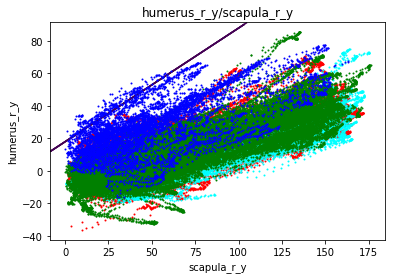

In [6]:
PlotData(5,17)

# Theta check

In [7]:
newparam = ['bias']
newparam.extend(param)

for cat in classes:
    ParamCheck = pd.DataFrame()
    ParamCheck['Params'] = newparam
    ParamCheck['Theta'] = list(Data[cat]['Model'].coef_)[0]
    ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Theta']))
    ParamCheck = ParamCheck.sort_values(by=['Absolute'] , ascending=False)
    print(ParamCheck)
    print('\n\n')

             Params     Theta  Absolute
0              bias -2.185522  2.185522
21  clavicula_z_dif -0.107887  0.107887
11    clavicula_r_y  0.107844  0.107844
14      scapula_l_y -0.104860  0.104860
7     clavicula_l_x -0.098584  0.098584
17      scapula_r_y -0.081766  0.081766
8     clavicula_l_y -0.078234  0.078234
12    clavicula_r_z  0.064718  0.064718
20  clavicula_y_dif -0.059708  0.059708
23    scapula_y_dif  0.055548  0.055548
9     clavicula_l_z -0.051231  0.051231
26    humerus_y_dif -0.049081  0.049081
10    clavicula_r_x  0.046986  0.046986
16      scapula_r_x  0.040993  0.040993
18      scapula_r_z -0.038102  0.038102
6       humerus_r_z -0.035840  0.035840
13      scapula_l_x -0.034734  0.034734
2       humerus_l_y  0.031272  0.031272
19  clavicula_x_dif -0.030202  0.030202
3       humerus_l_z  0.029509  0.029509
24    scapula_z_dif  0.027149  0.027149
1       humerus_l_x  0.022603  0.022603
27    humerus_z_dif -0.019417  0.019417
15      scapula_l_z  0.018555  0.018555


In [8]:
y_true = Data['c1']['y_test']
y_pred = Data['c1']['Model'].predict(Data['c1']['X_test'])

TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

# tabel printen

print('Informationi matrix %s' % cat)
tab = [["pred pos", TP, FP], ["pred neg", FN, TN]]
print(pd.DataFrame(tab, columns=["", "pos", "neg"]))
print()
print("recall: ", recall_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred))
print("accuracy: ", accuracy_score(y_true, y_pred))
print('\n\n')

Informationi matrix c4
              pos    neg
0  pred pos  3295   1392
1  pred neg  2450  19919

recall:  0.5735422106179286
precision:  0.7030083208875614
accuracy:  0.8579982259018333





# Information matrix

In [9]:
for cat in classes:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html
    y_true = Data[cat]['y_test']
    y_pred = Data[cat]['Model'].predict(Data[cat]['X_test'])

    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

    # tabel printen

    print('Informationi matrix %s' % cat)
    tab = [["pred pos", TP, FP], ["pred neg", FN, TN]]
    print(pd.DataFrame(tab, columns=["", "pos", "neg"]))
    print()
    print("recall: ", recall_score(y_true, y_pred))
    print("precision: ", precision_score(y_true, y_pred))
    print("accuracy: ", accuracy_score(y_true, y_pred))
    print('\n\n')

Informationi matrix c1
              pos    neg
0  pred pos  3295   1392
1  pred neg  2450  19919

recall:  0.5735422106179286
precision:  0.7030083208875614
accuracy:  0.8579982259018333



Informationi matrix c2
              pos    neg
0  pred pos  3942   2466
1  pred neg  6726  13922

recall:  0.3695163104611924
precision:  0.6151685393258427
accuracy:  0.6602602010644589



Informationi matrix c3
              pos    neg
0  pred pos  4213   2290
1  pred neg  4822  15731

recall:  0.4662977310459325
precision:  0.6478548362294325
accuracy:  0.7371377882909521



Informationi matrix c4
             pos    neg
0  pred pos  955    188
1  pred neg  653  25260

recall:  0.5939054726368159
precision:  0.8355205599300087
accuracy:  0.9689163217031342





# Analyse Percentages

In [10]:
#collumn namen renamen
for num, i in enumerate(classes):
    Data[i]['result'].rename(columns={ Data[i]['result'].columns[2]: "percentagecat%s" % str(num+1) },inplace=True)


#alle resultaten in 1 df joinen
resultdf5 = pd.concat([Data['c1']['result'], \
                       Data['c2']['result'], \
                       Data['c3']['result'], \
                       Data['c4']['result']], axis=1, join='inner')

# Voorbereiden datafarme, creeer het antwoord (groundtruth) en een bias
resultdf5.reset_index(inplace=True)
resultdf5['groundtruth'] = resultdf5['pat'].apply(CategorieStringToNum)
resultdf5['bias'] = 1
resultdf5.set_index('pat', drop=True, inplace=True)

param = ['bias','percentagecat1', 'percentagecat2', 'percentagecat3', 'percentagecat4']
yValueColumn = 'groundtruth'    
X_param = np.matrix(resultdf5[param])
y = resultdf5['groundtruth']

# Use SKLearn.linear_model
model_param = LinearRegression()
model_param.fit(X_param, y)
y_pred = model_param.predict(X_param)

# kolom met voorspelling toevoegen aan data)
resultdf5['predict'] = y_pred
resultdf5['predict_round'] = [int(round(i)) if i <4 and i > 1 else 4 if i > 4 else 1 for i in y_pred]
resultdf5 = resultdf5.drop(['countF', 'countT', ], axis=1)
resultdf5.reset_index(inplace=True)

## maak tabel (df4) met per patient het aantal sampels dat true en false gelabeld wordt.

# aantal false tellen
df2 = resultdf5.groupby(['pat','predict_round']).size().to_frame('countF').reset_index()
df2.set_index(['pat', 'predict_round'], inplace=True)
df2 = df2.unstack(-1)
df2 = df2.join(resultdf5[['pat',yValueColumn]].drop_duplicates(subset=['pat', yValueColumn]).set_index('pat'))


df2['percentage'] = np.vectorize(CalculatePerc)(df2[yValueColumn], df2['countF', 1],df2['countF', 2],df2['countF', 3],df2['countF', 4])
df2.sort_values(by=['percentage'],ascending=False)
print(df2)

      (countF, 1)  (countF, 2)  (countF, 3)  (countF, 4) groundtruth  \
pat                                                                    
1001          1.0          NaN          NaN          NaN           1   
1002          NaN          1.0          NaN          NaN           1   
1003          1.0          NaN          NaN          NaN           1   
1004          NaN          1.0          NaN          NaN           1   
1005          1.0          NaN          NaN          NaN           1   
1006          1.0          NaN          NaN          NaN           1   
1007          1.0          NaN          NaN          NaN           1   
1008          1.0          NaN          NaN          NaN           1   
1010          1.0          NaN          NaN          NaN           1   
1011          1.0          NaN          NaN          NaN           1   
1012          1.0          NaN          NaN          NaN           1   
1013          1.0          NaN          NaN          NaN        

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [11]:
ParamCheck = pd.DataFrame()
ParamCheck['Params'] = param
ParamCheck['Theta'] = list(model_param.coef_)
ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Theta']))
ParamCheck = ParamCheck.sort_values(by=['Absolute'] , ascending=False)
print(ParamCheck)

           Params     Theta  Absolute
4  percentagecat4  0.022990  0.022990
1  percentagecat1 -0.013944  0.013944
3  percentagecat3  0.013841  0.013841
2  percentagecat2  0.000602  0.000602
0            bias  0.000000  0.000000


# Things for later
## Check most importent parameter

    ParamCheck = pd.DataFrame()
    ParamCheck['Params'] = list(df_cleaned[Xcolumns])
    ParamCheck['Values'] = list(lr.coef_)[0]
    ParamCheck['Absolute'] = np.absolute(list(ParamCheck['Values']))
    ParamCheck = ParamCheck.sort_values(by=['Absolute'],ascending=False)

## Check if plot_decision_boundary is correct
<span style=" text-decoration: line-through;">plot_decision_boundary werkt nog via de oude manier, niet via sklearn, en gebruikt misschien niet dezelfdemanier als het model?
    Voor nu is dat misschien nog oke, maar als we geen lineare regressie meer gaan doen niet meer.</span>